In [1]:
import rpy2
import scipy
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scrublet as scr
import decoupler as dc
from scipy import sparse
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
de

# **Table of contents**:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

## **1. hdWGCNA in single-cell data**

Here we use `hdWGCNA` to perform co-expression network analysis on single-cell data. 

`hdWGCNA` is an R package for performing `weighted gene co-expression network analysis (WGCNA)` in high dimensional transcriptomics data such as single-cell RNA-seq or spatial transcriptomics. hdWGCNA is highly modular and can construct co-expression networks across multi-scale cellular and spatial hierarchies. hdWGNCA identifies robust modules of inerconnected genes, and provides context for these modules through various biological knowledge sources. hdWGCNA requires data formatted as Seurat objects, one of the most ubiquitous formats for single-cell data. 

`Note: hdWGCNA is under active development, so you may run into errors and small typos. We welcome users to write GitHub issues to report bugs, ask for help, and to request potential enhancements.`

Explore the full capabilites of hWGNA in the following publications:

- [**Morabito et al. bioRxiv 2022**](https://www.biorxiv.org/content/10.1101/2022.09.22.509094v1)
- [**Morabito & Miyoshi et al. Nature Genetics 2021**](https://www.nature.com/articles/s41588-021-00894-z)


Here, apply hdWGCNA to the processed single-nucleus RNA-seq (snRNA-seq) datasets. These dataset have already been fully processed using a standard single-cell transcritpomics analysis pipelines (please see the following notebooks, `preprocessing_data_integration`, `preprocessing_quality_control`, `preprocessing_cluster_annotation`). 


If you would like to apply this notebook to your own dataset, you first need to satisfy the following prerequisites:

A single-cell or single-nucleus transcriptomics dataset in Seurat format.
Normalize the gene expression matrix NormalizeData.
Identify highly variable genes VariableFeatures.
Scale the normalized expression data ScaleData
Perform dimensionality reduction RunPCA and batch correction if needed RunHarmony.
Non-linear dimensionality reduction RunUMAP for visualizations.
Group cells into clusters (FindNeighbors and FindClusters).
An example of running the prerequisite data processing steps can be found in the Seurat Guided Clustering Tutorial.


In [4]:
%%R
suppressPackageStartupMessages({
    library(WGCNA)
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)


    # single-cell analysis package
    library(Seurat)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)


# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
# enableWGCNAThreads(nThreads = 4)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## **Prepare data**

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
save_prefix = 'allen_mtg'

adata_annot = sc.read_h5ad(f'../data/processed/{save_prefix}/{save_prefix}_mapped_anndata.h5ad')
adata_annot.obs_names_make_unique()
adata_annot.var_names_make_unique()
adata_annot.X = adata_annot.layers['counts'].copy()
del adata_annot.obsm, adata_annot.layers, adata_annot.varm, adata_annot.uns, adata_annot.obsp


In [6]:
map_meta = True
filter_genes = "TRUE"
subject_id = 'individualID'                # for leng this is `PatientID` for mathys is 'Subject', and 'individualID' for allen
gene_celltype_threshold = 0.05          # determines number of cells the gene must be expressed in 
covariates = ['None']                   # list of covariates to be accounted for in regression.
deg_method =  'DESeq2-Wald'
test_names = ['late_vs_early', 'early_vs_no', 'late_vs_no', 'ad_vs_no']
celltypes = ["OPC"] #["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"]
metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv' 
meta = pd.read_csv(metadata, encoding_errors='ignore')

In [7]:
# map the pathology group to teh subject id in .obs

adata_annot.obs['pathology.group'] = adata_annot.obs[subject_id].map(dict(zip(meta[subject_id].astype(str), meta['pathology.group'])))

In [8]:
%%R -i adata_annot -i subject_id -i gene_celltype_threshold -i celltypes -i test_names -i save_prefix

print(adata_annot)
print('loaded data into memory for recursive use')

class: SingleCellExperiment 
dim: 17950 104349 
metadata(0):
assays(1): X
rownames(17950): A1BG A1CF ... ZZEF1 ZZZ3
rowData names(10): mt n_cells_by_counts ... dispersions
  dispersions_norm
colnames(104349): AAAGGTAGTACGGCAA AACCAACGTGGATCGA ...
  TTTGTTGCAACAGTGG TTTGTTGGTGAATTGA
colData names(106): ID name ... cell_type predictions
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
[1] "loaded data into memory for recursive use"


In [9]:
del adata_annot

## **Set up Seurat object for WGCNA**

Before running hdWGCNA, we first have to set up the Seurat object. Most of the information computed by hdWGCNA is stored in the Seurat object’s `@misc slot`. 

A single Seurat object can hold multiple hdWGCNA experiments, for example representing different cell types in the same single-cell dataset. Notably, since we consider hdWGCNA to be a downstream data analysis step, we do not need to subset the Seurat object after `SetupForWGCNA` has been run.

Here we will set up the Seurat object using the `SetupForWGCNA` function, specifying the name of the hdWGNCA experiment. This function also selects the genes that will be used for WGCNA. We can aslo select genes using three different approaches using the gene_select parameter:


- `variable`: use the genes stored in the Seurat object’s `VariableFeatures`.

- `fraction`: use genes that are expressed in a certain fraction of cells for in the whole dataset or in each group of cells, specified by group.by.

- `custom`: use genes that are specified in a custom list.

Here, we will select genes that are expressed in at least 5% of cells in each cell-type, and we will rename our hdWGCNA experiment.


In [10]:
%%R -o seurat_obj

seurat_obj <- as.Seurat(adata_annot, counts = "X", data = "X")

print(seurat_obj)

# Perform dimensionality reduction and plot

seurat_obj <- FindVariableFeatures(seurat_obj)
seurat_obj <- ScaleData(seurat_obj)
seurat_obj <- RunPCA(seurat_obj)
seurat_obj <- RunHarmony(seurat_obj, group.by.vars = subject_id)
seurat_obj <- RunUMAP(seurat_obj, reduction='harmony', n.neighbors=15, dims=1:30, min.dist=0.1)

p <- DimPlot(seurat_obj, group.by = "cell_type", label = TRUE) +
     umap_theme() + ggtitle("leng") + NoLegend()

# Save plot to PDF
pdf(file = paste0("../results/hdWGCNA/UMAP/", save_prefix, "_integrated_umap.pdf"), width = 4, height = 4, useDingbats = FALSE)
print(p)
dev.off()

# create a hdWGCNA experiment for each celltype
seurat_dat <- seurat_obj
seurat_obj <- list()

for (cur_cell_type in celltypes){

  seurat_obj[[cur_cell_type]] <- subset(seurat_dat, cell_type == cur_cell_type)

  print(paste0('Creating hdWGNA Experiment for ', toupper(cur_cell_type)))

  seurat_obj[[cur_cell_type]] <- SetupForWGCNA(
    seurat_obj[[cur_cell_type]],
    gene_select = "fraction", # the gene selection approach
    fraction = 0.05,          # fraction of cells that a gene needs to be expressed in order to be included
    group.by = 'cell_type',   # 
    wgcna_name = toupper(substr(cur_cell_type, 1, 3)),        # the name of the hdWGCNA experiment
  )
  print(seurat_obj[[cur_cell_type]])
}

rm(seurat_dat)
rm(adata_annot)

An object of class Seurat 
17950 features across 104349 samples within 1 assay 
Active assay: originalexp (17950 features, 0 variable features)
[1] "Creating hdWGNA Experiment for OPC"
[1] 17950  2838
An object of class Seurat 
17950 features across 2838 samples within 1 assay 
Active assay: originalexp (17950 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap


Send list to R interface

In [11]:
# convert nested list of Seurat object into Rpy2 object 

seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

## **Construct metacells**

After setting up our Seurat object, the first step in running the hdWGCNA pipeine in hdWGCNA is to construct metacells from the single-cell dataset. 

Briefly, `metacells are aggregates of small groups of similar cells originating from the same biological sample of origin.` The k-Nearest Neighbors (KNN) algorithm is used to identify groups of similar cells to aggregate, and then the average or summed expression of these cells is computed, thus yielding a metacell gene expression matrix. `The sparsity of the metacell expression matrix is considerably reduced` when compared to the original expression matrix, and therefore it is preferable to use. We were originally motivated to use metacells in place of the original single cells because correlation network approaches such as WGCNA are sensitive to data sparsity. Furthermore, single-cell epigenomic approaches, such as Cicero, employ a similar metacell aggregation approach prior to constructing co-accessibility networks.

hdWGCNA includes a function MetacellsByGroups to construct metacell expression matrices given a single-cell dataset. This function constructs a new Seurat object for the metacell dataset which is stored internally in the hdWGCNA experiment. 

The `group.by` parameter determines which groups metacells will be constructed in. 

`We only want to construct metacells from cells that came from the same biological sample of origin, so it is critical to pass that information to hdWGCNA via the group.by parameter.` 

Additionally, we usually construct metacells for each cell type separately. `Thus, in this example, we are grouping by Sample and cell_type to achieve the desired result.`

The number of cells to be aggregated k should be tuned based on the size of the input dataset, in general a lower number for k can be used for small datasets. `Generally use k values between 20 and 75 for 40,039 cells`, ranging from 890 to 8,188 in each biological sample, and here we used k=25. The amount of allowable overlap between metacells can be tuned using the max_shared argument.

Note: The metacell aggregation approach does not yield good results for extremely underrepresented cell types. For example, the brain vascular cells (pericytes and endothelial cells), thus we have excluded them from this analysis. 

`MetacellsByGroups `has a parameter min_cells to exclude groups that are smaller than a specified number of cells. Errors are likely to arise if the selected value for min_cells is too low.

`Here we construct metacells and normalize in each hdWGCNA experiment`

The resulting expression matrix is obtained using the following code:

In [12]:
%%R -i seurat_obj -o seurat_obj

# construct metacells in each group for each wgnca experiment

for (cell_type in celltypes){

  print(paste0('Constructing MetaCells in hdWGCNA Experiment for ', toupper(cell_type)))
  
  seurat_obj[[cell_type]] <- MetacellsByGroups(
      
    seurat_obj = seurat_obj[[cell_type]],
    group.by = c("cell_type", subject_id), # specify the columns in seurat_obj@meta.data to group by
    reduction = 'harmony',  # select the dimensionality reduction to perform KNN on
    k = 25, # nearest-neighbors parameter
    max_shared = 10, # maximum number of shared cells between two metacells
    ident.group = 'cell_type', # set the Idents of the metacell seurat object
    wgcna_name = toupper(substr(cell_type, 1, 3)),        # the name of the hdWGCNA experiment
    )

    # normalize metacell expression matrix:
  seurat_obj[[cell_type]] <- NormalizeMetacells(seurat_obj[[cell_type]],  wgcna_name = toupper(substr(cell_type, 1, 3)))
}


[1] "Constructing MetaCells in hdWGCNA Experiment for OPC"


In [13]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

## **Process the Metacell Seurat Object**

Since we store the Metacell expression information as its own Seurat object, we can run Seurat functions on the metacell data. We can get the metacell object from the hdWGCNA experiment using `GetMetacellObject.`

In [14]:
# %%R -i seurat_obj -o metacell_obj

# metacell_obj <- list()
# for (cell_type in celltypes){
#     print(paste0('Obtaining MetaCells in hdWGCNA Experiment for ', toupper(cell_type)))
#     metacell_obj[[cell_type]] <- GetMetacellObject(seurat_obj[[cell_type]] , 
#                                         wgcna_name = toupper(substr(cell_type, 1, 3))       # the name of the hdWGCNA experiment
#                                      )
#     print(metacell_obj[[cell_type]])
# }

Here we use wrapper functions to process the metacell object and visualize one of the aggregated expression profiles in two dimensions with UMAP.

In [15]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in celltypes){

    print(paste0('Processing MetaCells in hdWGCNA Experiment for ', toupper(cell_type)))
    
    seurat_obj[[cell_type]]  <- NormalizeMetacells(seurat_obj[[cell_type]])
    seurat_obj[[cell_type]]  <- ScaleMetacells(seurat_obj[[cell_type]] , features=VariableFeatures(seurat_obj[[cell_type]]))
    seurat_obj[[cell_type]]  <- RunPCAMetacells(seurat_obj[[cell_type]] , features=VariableFeatures(seurat_obj[[cell_type]]))
    seurat_obj[[cell_type]]  <- RunHarmonyMetacells(seurat_obj[[cell_type]] , group.by.vars=subject_id)
    seurat_obj[[cell_type]]  <- RunUMAPMetacells(seurat_obj[[cell_type]] , reduction='harmony', dims=1:15)


    p1 <- DimPlotMetacells(seurat_obj[[cell_type]] , group.by='cell_type') + umap_theme() + ggtitle("Cell Type")
    p2 <- DimPlotMetacells(seurat_obj[[cell_type]] , group.by=subject_id) + umap_theme() + ggtitle(subject_id)

    p1 | p2

}

[1] "Processing MetaCells in hdWGCNA Experiment for OPC"


In [16]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

## **Co-expression network analysis**

### **Set up the expression matrix**

Here we specify the expression matrix that we will use for network analysis. We only include a single cell-type of interest per run/simulation, so we have to subset our expression data prior to constructing the network. hdWGCNA includes the `SetDatExpr` function to store the transposed expression matrix for a given group of cells that will be used for downstream network analysis.

The metacell expression matrix is used by default `(use_metacells=TRUE)`, but hdWGCNA does allow for the single-cell expression matrix to be used if desired.. This function allows the user to specify which slot to take the expression matrix from, for example if the user wanted to apply SCTransform normalization instead of NormalizeData.

In [17]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in celltypes){

    print(paste0('Setting up expression matrix in hdWGCNA Experiment for ', toupper(cell_type)))

    seurat_obj[[cell_type]] <- SetDatExpr(
      seurat_obj[[cell_type]],
      group_name = cell_type, # the name of the group of interest in the group.by column
      group.by = 'cell_type', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
      assay = 'originalexp', # using RNA assay
      slot = 'data', # using normalized data
      wgcna_name = toupper(substr(cell_type, 1, 3)) # the name of the hdWGCNA experiment
    )
}

[1] "Setting up expression matrix in hdWGCNA Experiment for OPC"


In [18]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

### **Select soft-power threshold**

Next we will select the “soft power threshold”. This is an extremely important step in the hdWGNCA pipleine (and for vanilla WGCNA). hdWGCNA constructs a gene-gene correlation adjacency matrix to infer co-expression relationships between genes. The correlations are raised to a power to reduce the amount of noise present in the correlation matrix, thereby retaining the strong connections and removing the weak connections. Therefore, it is critical to determine a proper value for the soft power threshold.

We use the function `TestSoftPowers` to perform a parameter sweep for different soft power thresholds. This function helps us to guide our choice in a soft power threshold for constructing the co-expression network by inspecting the resulting network topology for different power values. The co-expression network should have a scale-free topology, therefore the TestSoftPowers function models how closely the co-expression network resembles a scale-free graph at different soft power thresholds. Furthermore, we use the function `PlotSoftPowers` to visualize the results of the parameter sweep.

The following code performs the parameter sweep and outputs a summary figure.

In [19]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/SoftPower/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in celltypes){
  
  print(paste0('Estinmating Soft-Power Threshold in hdWGCNA Experiment for ', toupper(cell_type)))

  # Test different soft powers:
  seurat_obj[[cell_type]] <- TestSoftPowers(
    seurat_obj[[cell_type]],
    networkType = 'signed', # you can also use "unsigned" or "signed hybrid"
    setDatExpr = TRUE,
    group.by = 'cell_type',
    group_name = cell_type,
  )

  # plot the results:
  plot_list <- PlotSoftPowers(seurat_obj[[cell_type]], 
                              # wgcna_name = toupper(substr(cell_type, 1, 3)) # the name of the hdWGCNA experiment
                              )

  # assemble with patchwork
  pdf(paste0(fig_dir, cell_type, '_SoftPower.pdf'), width=12, height=8)
  print(wrap_plots(plot_list, ncol=2))
  dev.off()

}

[1] "Estinmating Soft-Power Threshold in hdWGCNA Experiment for OPC"
pickSoftThreshold: will use block size 4104.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4104 of 10901
   ..working on genes 4105 through 8208 of 10901
   ..working on genes 8209 through 10901 of 10901
   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k.  max.k.
1      1  0.17200  8.98          0.919 5.58e+03  5.60e+03 6150.00
2      2  0.00693 -0.86          0.986 2.91e+03  2.91e+03 3620.00
3      3  0.18400 -3.33          0.965 1.54e+03  1.53e+03 2220.00
4      4  0.45400 -4.28          0.935 8.31e+02  8.11e+02 1410.00
5      5  0.73500 -4.63          0.955 4.55e+02  4.35e+02  920.00
6      6  0.87400 -4.44          0.976 2.53e+02  2.36e+02  616.00
7      7  0.92000 -3.95          0.982 1.43e+02  1.30e+02  423.00
8      8  0.95100 -3.55          0.985 8.22e+01  7.22e+01  296.00
9      9  0.97600 -3.20          0.992 4.81e+01  4.07e+01  212.00
10    10  0.9840

In [20]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

The general guidance for WGCNA and hdWGCNA is to `pick the lowest soft power threshold that has a Scale Free Topology Model Fit greater than or equal to 0.8`. Later on, the `ConstructNetwork `will automatically select the soft power threshold if we do not provide one.

The output table from the parameter sweep is stored in the hdWGCNA experiment and can be accessed using the GetPowerTable function for further inspection:

In [21]:
# %%R -i seurat_obj -o seurat_obj

# power_table <- GetPowerTable(seurat_obj)
# head(power_table)

### **Construct co-expression network**

We now have everything that we need to construct our co-expression network. Here we use the hdWGCNA function ConstructNetwork, which calls the WGCNA function blockwiseConsensusModules under the hood. This function has quite a few parameters to play with if for advanced use cases, but we use default parameters that work well with many single-cell datasets. 

The parameters for blockwiseConsensusModules can be passed directly to ConstructNetwork with the same parameter names.

The following code construtcts the co-expression network using the soft power threshold selected above:

In [22]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in celltypes) {
  
  print(paste0('Constructing co-expression network in hdWGCNA Experiment for ', toupper(cell_type)))
  
  tryCatch({
    # construct co-expression network:
    seurat_obj[[cell_type]] <- ConstructNetwork(
      seurat_obj[[cell_type]], 
      soft_power = NULL, # Set to NULL so that the ConstructNetwork function obtains it automatically (Scale Free Topology Model Fit >= 0.8)
      setDatExpr = FALSE,
      overwrite_tom = TRUE,
      tom_name = toupper(substr(cell_type, 1, 3)) # name of the topological overlap matrix written to disk set as the name of the hdWGCNA experiment 
    )
  }, error = function(e) {
    print(paste0('Error encountered while processing ', toupper(cell_type)))
    print(paste0(toupper(cell_type), ' dropped from experiment'))
    # Code to handle the error condition
    seurat_obj <- seurat_obj[names(seurat_obj) != cell_type]
    assign("seurat_obj", seurat_obj, envir = .GlobalEnv) # Update the modified seurat_obj in the global environment

  },  
  message = function(m) {
    print(paste0('Error encountered while processing ', toupper(cell_type)))
    print(paste0(toupper(cell_type), ' dropped from experiment'))
    # Code to handle the error condition
    seurat_obj <- seurat_obj[names(seurat_obj) != cell_type]
    assign("seurat_obj", seurat_obj, envir = .GlobalEnv) # Update the modified seurat_obj in the global environment

  }) 
  
}


print(names(seurat_obj))


[1] "Constructing co-expression network in hdWGCNA Experiment for OPC"
Soft power not provided. Automatically using the lowest power that meets 0.8 scale-free topology fit. Using soft_power = 6
 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..
[1] "OPC"


In [23]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

hdWGCNA also includes a function PlotDendrogram to visualize the WGCNA dendrogram, a common visualization to show the different co-expression modules resulting from the network analysis. Each leaf on the dendrogram represents a single gene, and the color at the bottom indicates the co-expression module assignment.


`Importantly, the “grey” module consists of genes that were not grouped into any co-expression module. The grey module should be ignored for all downstream analysis and interpretation.`

In [24]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/dendrogram/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

tryCatch({
    for (cell_type in names(seurat_obj)){
        # print(paste0('Constructing co-expression networkd in hdWGCNA Experiment for ', toupper(cell_type)))
        pdf(paste0(fig_dir, cell_type, "_dendro.pdf"), height=2, width=4)
        PlotDendrogram(seurat_obj[[cell_type]], main='hdWGCNA Dendrogram')
        dev.off()
    }
}, error = function(e){
    NULL
})

In [25]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **Optional: inspect the topoligcal overlap matrix (TOM)**

hdWGCNA represents the co-expression network as a `topoligcal overlap matrix (TOM)`. This is a square matrix of genes by genes, where each value is the topoligcal overlap between the genes. The TOM is written to the disk when running ConstructNetwork, and we can load it into R using the GetTOM function. 

We may wish to inspect the TOM for custom downstream analyses.



In [26]:
# %%R -i seurat_obj -o seurat_obj -o TOM

# TOM <- GetTOM(seurat_obj)

### **Module Eigengenes and Connectivity**

### Compute harmonized module eigengenes

`Module Eigengenes (MEs)` are a commonly used metric to summarize the gene expression profile of an entire co-expression module. Briefly, module eigengenes are computed by performing principal component analysis (PCA) on the subset of the gene expression matrix comprising each module. `The first PC of each of these PCA matrices are the MEs.`

Dimensionality reduction techniques are a very hot topic in single-cell genomics. It is well known that technical artifacts can muddy the analysis of single-cell datasets, and over the years there have been many methods that aim to reduce the effects of these artifacts. Therefore it stands to reason that `MEs would be subject to these technical artifacts as well`, and hdWGCNA seeks to alleviate these effects.

`hdWGCNA includes a function ModuleEigengenes` to compute module eigengenes in single cells. Additionally, we can apply Harmony batch correction to the MEs, yielding harmonized module eigengenes (hMEs).

The following code performs the module eigengene computation `harmonizing by the Sample of origin using the group.by.vars parameter.`

In [27]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){

    print(paste0('Estimating module eigen-genes in hdWGCNA Experiment for ', toupper(cell_type)))
    
    # need to run ScaleData first or else harmony throws an error:
    seurat_obj[[cell_type]] <- ScaleData(seurat_obj[[cell_type]], features=VariableFeatures(seurat_obj[[cell_type]]))

    # compute all MEs in the full single-cell dataset
    seurat_obj[[cell_type]] <- ModuleEigengenes(
    seurat_obj[[cell_type]],
    group.by.vars=subject_id
    )
    print('----------------')

}

[1] "Estimating module eigen-genes in hdWGCNA Experiment for OPC"
[1] "yellow"
[1] "grey"
[1] "turquoise"
[1] "blue"
[1] "magenta"
[1] "brown"
[1] "black"
[1] "green"
[1] "red"
[1] "purple"
[1] "tan"
[1] "pink"
[1] "greenyellow"
[1] "salmon"
[1] "cyan"
[1] "----------------"


In [28]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

The ME matrices are stored as a matrix where each row is a cell and each column is a module. This matrix can be extracted from the Seurat object using the GetMEs function, which retrieves the hMEs by default.

In [29]:
%%R -i seurat_obj -o seurat_obj -o hMEs -o MEs

hMEs <- list()
MEs <- list()

for (cell_type in names(seurat_obj)){
    print(paste0('Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for ', toupper(cell_type)))
    
    # harmonized module eigengenes:
    hMEs[[cell_type]] <- GetMEs(seurat_obj[[cell_type]])

    # module eigengenes:
    MEs[[cell_type]] <- GetMEs(seurat_obj[[cell_type]], harmonized=FALSE)
}

[1] "Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for OPC"


In [30]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### Compute module connectivity

In co-expression network analysis, we often want to focus on the `“hub genes”`,`those which are highly connected within each module.` Therefore we wish to determine the `eigengene-based connectivity, also known as kME`, of each gene. 

hdWGCNA includes the ModuleConnectivity to compute the kME values in the full single-cell dataset, rather than the metacell dataset. This function essentially computes pairwise correlations between genes and module eigengenes. kME can be computed for all cells in the dataset, but we recommend computing kME in the cell type or group that was previously used to run ConstructNetwork.

In [31]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){

  print(paste0('Estimating module connectivity in hdWGCNA Experiment for ', toupper(cell_type)))

  # compute eigengene-based connectivity (kME):
  seurat_obj[[cell_type]] <- ModuleConnectivity(
    seurat_obj[[cell_type]],
    group.by = 'cell_type', 
    group_name = cell_type
  )
  
}

[1] "Estimating module connectivity in hdWGCNA Experiment for OPC"


In [32]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

For convenience, we re-name the hdWGCNA modules to indicate that they are from the Excitatory neuron group.

In [33]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){

  print(paste0('Renaming modules in hdWGCNA Experiment for ', toupper(cell_type)))

  # rename the modules
  seurat_obj[[cell_type]] <- ResetModuleNames(
    seurat_obj[[cell_type]],
    new_name = paste0(toupper(substr(cell_type, 1, 3)), "-M"),
    wgcna_name = toupper(substr(cell_type, 1, 3)) # the name of the hdWGCNA experiment,
  )
}

[1] "Renaming modules in hdWGCNA Experiment for OPC"


In [34]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

We also reset module colors

In [35]:
%%R -i seurat_obj -o seurat_obj 



library(MetBrewer)

for (cell_type in names(seurat_obj)){

  print(paste0('Resetting module colors in hdWGCNA Experiment for ', toupper(cell_type)))


  modules <- GetModules(seurat_obj[[cell_type]])
  mods <- levels(modules$module)
  mod_colors <- dplyr::select(modules, c(module, color)) %>%
    distinct %>% arrange(module) %>% .$color
  n_colors <- length(mod_colors) -1

  new_colors <- paste0(met.brewer("Signac", n=n_colors, type='discrete'))
  new_colors <- sample(new_colors)
  seurat_obj[[cell_type]] <- ResetModuleColors(seurat_obj[[cell_type]], new_colors)

}


[1] "Resetting module colors in hdWGCNA Experiment for OPC"


In [36]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

We can visualize the genes in each module ranked by kME using the PlotKMEs function.

In [37]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/ModuleConnectivity/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){
    
    print(paste0('Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for ', toupper(cell_type)))

    # plot genes ranked by kME for each module

    p <- PlotKMEs(seurat_obj[[cell_type]], ncol=5)

    pdf(paste0(fig_dir, cell_type, '_KMEs.pdf'), width=12, height=8)
    print(p)
    dev.off()
}

[1] "Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for OPC"
[1] "OPC-M1"
[1] "OPC-M2"
[1] "OPC-M3"
[1] "OPC-M4"
[1] "OPC-M5"
[1] "OPC-M6"
[1] "OPC-M7"
[1] "OPC-M8"
[1] "OPC-M9"
[1] "OPC-M10"
[1] "OPC-M11"
[1] "OPC-M12"
[1] "OPC-M13"
[1] "OPC-M14"
[1] "OPC-M1"
[1] "OPC-M2"
[1] "OPC-M3"
[1] "OPC-M4"
[1] "OPC-M5"
[1] "OPC-M6"
[1] "OPC-M7"
[1] "OPC-M8"
[1] "OPC-M9"
[1] "OPC-M10"
[1] "OPC-M11"
[1] "OPC-M12"
[1] "OPC-M13"
[1] "OPC-M14"


In [38]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### Getting the module assignment table

hdWGCNA allows for easy access of the module assignment table using the GetModules function. 

This table consists of three columns: 

- gene_name stores the gene’s symbol or ID, 
- module stores the gene’s module assignment, and 
- color stores a color mapping for each module, 

which is used in many downstream plotting steps. If ModuleConnectivity has been called on this hdWGCNA experiment, this table will have additional columns for the kME of each module.

In [39]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){
    
    print(paste0('Obtain Module Assignment Table in hdWGCNA Experiment for ', toupper(cell_type)))

    # get the module assignment table:
    modules <- GetModules(seurat_obj[[cell_type]])

    # show the first 6 columns:
    print(head(modules[,1:6]))
}

[1] "Obtain Module Assignment Table in hdWGCNA Experiment for OPC"
      gene_name module   color kME_OPC-M1   kME_grey kME_OPC-M2
A2M         A2M OPC-M1 #9b3441  0.2245655 0.05185938 0.01187656
AAAS       AAAS   grey    grey  0.1103003 0.15419261 0.14485426
AACS       AACS   grey    grey  0.1136716 0.20582454 0.22261105
AADAT     AADAT   grey    grey  0.2531230 0.27139765 0.25258343
AAGAB     AAGAB   grey    grey  0.2077413 0.27707943 0.28005958
AAK1       AAK1 OPC-M2 #9f5691  0.4496742 0.56295352 0.54802637


In [40]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

A table of the top N hub genes sorted by kME can be extracted using the GetHubGenes function.

In [41]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){
    
    print(paste0('Obtain Hub Genes in hdWGCNA Experiment for ', toupper(cell_type)))

    # get hub genes
    hub_df <- GetHubGenes(seurat_obj[[cell_type]], n_hubs = 10)

    print(head(hub_df))
}

[1] "Obtain Hub Genes in hdWGCNA Experiment for OPC"
  gene_name module       kME
1     HMGN1 OPC-M1 0.4771302
2     TRPC1 OPC-M1 0.4898684
3      RCN2 OPC-M1 0.4903589
4   SPARCL1 OPC-M1 0.4967821
5     ARMC8 OPC-M1 0.5065546
6    MFSD4B OPC-M1 0.5070362


In [42]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

This wraps up the critical analysis steps for hdWGCNA, let's save our output.

In [43]:
%%R -i seurat_obj -o seurat_obj

dat_dir = paste0("../results/hdWGCNA/SeuratObject/", save_prefix, '/')

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){
    
    print(paste0('Saving hdWGCNA object in hdWGCNA Experiment for ', toupper(cell_type)))

    saveRDS(seurat_obj[[cell_type]], file=paste0(dat_dir, cell_type, '_hdWGCNA_object.rds'))

}

[1] "Saving hdWGCNA object in hdWGCNA Experiment for OPC"


In [44]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Compute hub gene signature scores**

Gene scoring analysis is a popular method in single-cell transcriptomics for computing a score for the overall signature of a set of genes. Seurat implements their own gene scoring technique using the `AddModuleScore` function, but there are also alternative approaches such as UCell.

hdWGCNA includes the function `ModuleExprScore` to compute gene scores for a give number of genes for each module, using either the Seurat or UCell algorithm. Gene scoring is an alternative way of summarizing the expression of a module from computing the module eigengene.

In [45]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){
    
  print(paste0('Compute hub gene scores in hdWGCNA Experiment for ', toupper(cell_type)))
    
  # compute gene scoring for the top 25 hub genes by kME for each module
  # with Seurat method
  seurat_obj[[cell_type]] <- ModuleExprScore(
    seurat_obj[[cell_type]],
    n_genes = 25,
    method='Seurat'
  )

  # compute gene scoring for the top 25 hub genes by kME for each module
  # with UCell method
  library(UCell)
  seurat_obj[[cell_type]] <- ModuleExprScore(
    seurat_obj[[cell_type]],
    n_genes = 25,
    method='UCell'
  )
}

[1] "Compute hub gene scores in hdWGCNA Experiment for OPC"
Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14
Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14


In [46]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Basic Visualization**

Here we visualize some results using hdWGCNA, and we employ some of Seurat’s built-in plotting tools to visualize our hdWGCNA results.



### **Module Feature Plots**

FeaturePlot is a commonly used Seurat visualization to show a feature of interest directly on the dimensionality reduction. hdWGCNA includes the ModuleFeaturePlot function to consruct FeaturePlots for each co-expression module colored by each module’s uniquely assigned color.

In [47]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/FeaturePlots/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){
    
  print(paste0('Module Feature Plots in hdWGCNA Experiment for ', toupper(cell_type)))
     
  # make a featureplot of hMEs for each module
  plot_list <- ModuleFeaturePlot(
    seurat_obj[[cell_type]],
    features='hMEs', # plot the hMEs
    order=TRUE, # order so the points with highest hMEs are on top
    # raster=TRUE, 
    # raster_dpi=400, 
    # alpha=1,
    # restrict_range=FALSE, 
    # raster_scale=0.25,
  )

  plot_list <- lapply(1:length(plot_list), function(x){
    plot_list[[x]] + NoLegend() + theme(plot.title=element_text(face='plain', vjust=0.25), plot.margin=margin(c(0,0,0,0)))
  })

  pdf(paste0(fig_dir, cell_type, "_featureplot_MEs.pdf"), height=10, width=5)
  print(wrap_plots(plot_list, ncol=3))
  dev.off()
}

[1] "Module Feature Plots in hdWGCNA Experiment for OPC"
[1] "OPC-M1"
[1] "OPC-M2"
[1] "OPC-M3"
[1] "OPC-M4"
[1] "OPC-M5"
[1] "OPC-M6"
[1] "OPC-M7"
[1] "OPC-M8"
[1] "OPC-M9"
[1] "OPC-M10"
[1] "OPC-M11"
[1] "OPC-M12"
[1] "OPC-M13"
[1] "OPC-M14"


In [48]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

We can also plot the hub gene signature score using the same function:

In [49]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/FeaturePlots/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){
    
  print(paste0('Module Feature Plots for HUB GENES in hdWGCNA Experiment for ', toupper(cell_type)))
     
  # make a featureplot of hMEs for each module
  plot_list <- ModuleFeaturePlot(
    seurat_obj[[cell_type]],
    features='scores',  # plot the hub gene scores
    order='shuffle', # order so cells are shuffled
    ucell = TRUE, # depending on Seurat vs UCell for gene scoring
    # raster=TRUE, 
    # raster_dpi=400, 
    # alpha=1,
    # restrict_range=FALSE, 
    # raster_scale=0.25,
  )

  plot_list <- lapply(1:length(plot_list), function(x){
    plot_list[[x]] + NoLegend() + theme(plot.title=element_text(face='plain', vjust=0.25), plot.margin=margin(c(0,0,0,0)))
  })

  pdf(paste0(fig_dir, cell_type, "_featureplot_hubs.pdf"), height=10, width=5)
  print(wrap_plots(plot_list, ncol=3))
  dev.off()
}

[1] "Module Feature Plots for HUB GENES in hdWGCNA Experiment for OPC"
[1] "OPC-M1"
[1] "OPC-M2"
[1] "OPC-M3"
[1] "OPC-M4"
[1] "OPC-M5"
[1] "OPC-M6"
[1] "OPC-M7"
[1] "OPC-M8"
[1] "OPC-M9"
[1] "OPC-M10"
[1] "OPC-M11"
[1] "OPC-M12"
[1] "OPC-M13"
[1] "OPC-M14"


In [50]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **Module Correlations**

hdWGCNA includes the ModuleCorrelogram function to visualize the correlation between each module based on their hMEs, MEs, or hub gene scores using the R package corrplot.

In [51]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/ModuleCorrelations/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

    print(paste0('Module Correlation in hdWGCNA Experiment for ', toupper(cell_type)))
    # plot module correlagram
    pdf(paste0(fig_dir, cell_type, "_correlogram.pdf"), height=10, width=5)
    ModuleCorrelogram(seurat_obj[[cell_type]])
    dev.off()
}

[1] "Module Correlation in hdWGCNA Experiment for OPC"


In [52]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **Seurat plotting functions**


The base Seurat plotting functions are also great for visualizing hdWGCNA outputs. Here we demonstrate plotting hMEs using DotPlot and VlnPlot. The key to using Seurat’s plotting functions to visualize the hdWGCNA data is to add it into the Seurat object’s @meta.data slot:

In [53]:
%%R -i seurat_obj -o seurat_obj -o mods

mods <- list()

for (cell_type in names(seurat_obj)){

    # get hMEs from seurat object
    MEs <- GetMEs(seurat_obj[[cell_type]], harmonized=TRUE)
    mods[[cell_type]] <- colnames(MEs); 
    mods[[cell_type]] <- mods[[cell_type]][mods[[cell_type]] != 'grey']
    
    
    # add hMEs to Seurat meta-data:
    seurat_obj[[cell_type]]@meta.data <- cbind(seurat_obj[[cell_type]]@meta.data, MEs)
}

In [54]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )


# convert nested list of Seurat object into Rpy2 object 
mods =  robjects.ListVector(
                        {
                            cell_type: mods[cell_type]
                     
                            for cell_type in mods.keys()
                        }
                    )

Now we can easily use Seurat’s DotPlot function:

In [55]:
%%R -i seurat_obj -i mods -o seurat_obj



fig_dir = paste0("../results/hdWGCNA/DotPlot/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){

  print(paste0('DotPlot for average expression of MEs in hdWGCNA Experiment for ', toupper(cell_type)))

  # plot with Seurat's DotPlot function
  p <- DotPlot(seurat_obj[[cell_type]], features=mods[[cell_type]], group.by = 'cell_type')

  # flip the x/y axes, rotate the axis labels, and change color scheme:
  p <- p +
    coord_flip() +
    RotatedAxis() +
    scale_color_gradient2(high='red', mid='grey95', low='blue')

  pdf(paste0(fig_dir, cell_type, "_dotplot.pdf"), height=10, width=5)
  print(p)
  dev.off()

}

[1] "DotPlot for average expression of MEs in hdWGCNA Experiment for OPC"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [56]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )


Here is another example where we use Seurat’s VlnPlot function:

In [57]:
# %%R -i seurat_obj -o seurat_obj


# for (cell_type in names(seurat_obj)){

#   print(paste0('ViolinPlot for average expression of MEs in hdWGCNA Experiment for ', toupper(cell_type)))

#   # Plot INH-M4 hME using Seurat VlnPlot function
#   p <- VlnPlot(
#     seurat_obj,
#     features = as.vector(mods[[cell_type]]),
#     group.by = 'cell_type',
#     pt.size = 0 # don't show actual data points
#   )

#   # add box-and-whisker plots on top:
#   p <- p + geom_boxplot(width=.25, fill='white')

#   # change axis labels and remove legend:
#   p <- p + xlab('') + ylab('hME') + NoLegend()

#   # plot output
#   pdf(paste0("../results/hdWGCNA/ViolinPlot/", save_prefix, '_', cell_type, "_violinplot.pdf"), height=10, width=5)
#   print(p)
#   dev.off()

# }


In [58]:
# # convert nested list of Seurat object into Rpy2 object 
# seurat_obj =  robjects.ListVector(
#                         {
#                             cell_type: seurat_obj[cell_type]
                     
#                             for cell_type in seurat_obj.keys()
#                         }
#                     )


# **Network Visualization**


Here, we visualize the co-expression networks made with hdWGCNA using the following functions:

- `ModuleNetworkPlot`, visualizes a separate network plot for each module, showing the top N genes by kME.
- `HubGeneNetworkPlot`, visualizes the network comprisng all modules with a given number of hub genes per module.
- `ModuleUMAPPlot`, visualizes all of the genes in the co-expression simultaneously using the UMAP dimensionality reduction algorithm.

## **Individual module network plots**


Here we demonstrate using the `ModuleNetworkPlot` function to visualize the network underlying the top 25 hub genes for each module. By default, this function creates a new folder called “ModuleNetworks”, and generates a .pdf figure for each module.



In [59]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0('../results/hdWGCNA/NetworkPlot/', save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('Module network plots in hdWGCNA Experiment for ', toupper(cell_type)))

  # individual module networks
  ModuleNetworkPlot(
    seurat_obj[[cell_type]],
    mods = "all",
    outdir = paste0(fig_dir, cell_type, '_hubNetworks/')
  )
}

[1] "Module network plots in hdWGCNA Experiment for OPC"
Writing output files to ../results/hdWGCNA/NetworkPlot/allen_mtg/OPC_hubNetworks/Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14
[1] "OPC-M1"
[1] "OPC-M2"
[1] "OPC-M3"
[1] "OPC-M4"
[1] "OPC-M5"
[1] "OPC-M6"
[1] "OPC-M7"
[1] "OPC-M8"
[1] "OPC-M9"
[1] "OPC-M10"
[1] "OPC-M11"
[1] "OPC-M12"
[1] "OPC-M13"
[1] "OPC-M14"


In this network, each node represents a gene, and each edge represents the co-expression relationship between two genes in the network. Each of these module network plots are colored based on the color column in the hdWGCNA module assignment table GetModules(seurat_obj). The top 10 hub genes by kME are placed in the center of the plot, while the remaining 15 genes are placed in the outer circle.

Optionally, certain visualization parameters can be changed in this plot:

- `edge.alpha`: determines the opacity of the network edges
- `vertex.size`: determines the size of the nodes
- `vertex.label.cex`: determines the font size of the gene label


In [60]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Combined hub gene network plots**

Here we will make a network plot combining all of the modules together using the `HubGeneNetworkPlot` function. 

This function takes the top n hub genes, and other randomly selected genes, and constructs a joint network using the force-directed graph drawing algorithm. For visual clarity, the number of edges in the network can be downsampled using the edge_prop parameter. In the following example, we visualize the top 3 hub genes and 6 other genes per module.



In [61]:
%%R -i seurat_obj -o seurat_obj



  fig_dir = paste0("../results/hdWGCNA/HubGeneNetworkPlot/", save_prefix, '/')
  if (!dir.exists(fig_dir)) {
    dir.create(fig_dir, recursive=TRUE)
  }


for (cell_type in names(seurat_obj)){

  print(paste0('Hubs Gene Network Plot in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  # Save plot to PDF
  pdf(file = paste0(fig_dir,  cell_type, "_allHubGeneNetwork.pdf"), width = 4, height = 4, useDingbats = FALSE)
  HubGeneNetworkPlot(
    seurat_obj[[cell_type]],
    n_hubs = 6,
    n_other=3,
    edge_prop = 0.75,
    mods = 'all',
    sample_edges = TRUE,
    return_graph = FALSE,
    edge.alpha = 0.25,
    vertex.label.cex = 0.25,
    hub.vertex.size = 6,
    other.vertex.size = 2,
    wgcna_name = NULL,

  )
  dev.off()

}

[1] "Hubs Gene Network Plot in hdWGCNA Experiment for OPC"
Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14

 OPC-M1    grey  OPC-M2  OPC-M3  OPC-M4  OPC-M5  OPC-M6  OPC-M7  OPC-M8  OPC-M9 
      9       3       9       9       9       9       9       9       9       9 
OPC-M10 OPC-M11 OPC-M12 OPC-M13 OPC-M14 
      9       9       9       9       8 
 [1] "#9b3441" "grey90"  "#9f5691" "#d8443c" "#f4c40f" "#aa7aa1" "#de597c"
 [8] "#2b9b81" "#fe9b00" "#e87b89" "#e6a2a6" "#633372" "#92c051"
[1] "here"
[1] 2207    4


In [62]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

As in the previous network plot, each node represents a gene and each edge represents a co-expression relationship. In this network, `we color intramodular edges with the module’s color, and intermodular edges gray.` The opacity of edges in this network is scaled by the strength of the co-expression relationship.

## **Applying UMAP to co-expression networks**

We have only visualized a subset of the co-expression network with an emphasis on the hub genes. Here, we use an alternative approach to visualize all genes in the co-expression network simultaneously. UMAP is a suitable method for visualizing high-dimensional data in two dimensions, and here we apply UMAP to embed the hdWGCNA network in a low-dimensional manifold.

hdWGCNA includes the function `RunModuleUMAP to run the UMAP algorithm on the hdWGCNA topological overlap matrix (TOM)`. For the UMAP analysis, we subset the columns in the TOM to only contain the top n hub genes by kME for each module. 

Therefore, the organization of each gene in UMAP space is dependent on that gene’s connectivity with the network’s hub genes. This function leverages the UMAP implementation from the uwot R package, so additional UMAP parameters for the uwot::umap function such as min_dist or spread can be included in RunModuleUMAP.

The following code demonstrates using the RunModuleUMAP function with 10 hub genes per module:

In [63]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in names(seurat_obj)){

  print(paste0('Obtaining Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  seurat_obj[[cell_type]] <- RunModuleUMAP(
    seurat_obj[[cell_type]],
    n_hubs = 5, # number of hub genes to include for the UMAP embedding
    n_neighbors=15, # neighbors parameter for UMAP
    min_dist=0.3, # min distance between points in UMAP space
    spread = 2,
  )
}

[1] "Obtaining Module UMAP in hdWGCNA Experiment for OPC"
Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14


In [64]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next we will make a simple visualization of the UMAP for Excitatory cells using ggplot2:

[1] "Store Module UMAP in hdWGCNA Experiment for OPC"


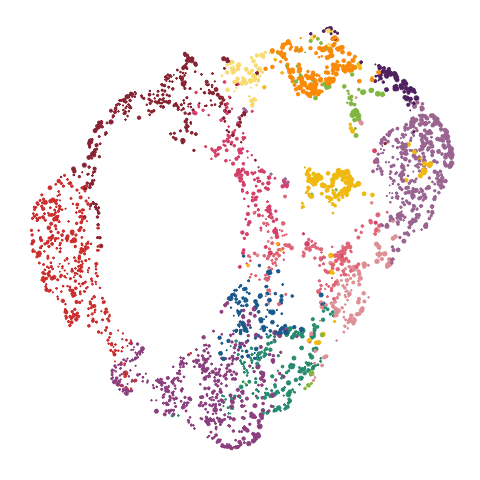

In [65]:
%%R -i seurat_obj -o seurat_obj

# get the hub gene UMAP table from the seurat object

umap_df <- list()

for (cell_type in names(seurat_obj)){

  print(paste0('Store Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  umap_df[[cell_type]] <- GetModuleUMAP(seurat_obj[[cell_type]])

}

# plot sample for Excitatory cells with ggplot
ggplot(umap_df[[celltypes[1]]], aes(x=UMAP1, y=UMAP2)) +
  geom_point(
   color=umap_df[[celltypes[1]]]$color, # color each point by WGCNA module
   size=umap_df[[celltypes[1]]]$kME*2 # size of each point based on intramodular connectivity
  ) +
  umap_theme()

In [66]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

In this plot, each point represents a single gene. The size of each dot is scaled by the gene’s kME for it’s assigned module. ggplot2 is sufficient to visualize the genes in the module UMAP, but here we are not visualizing the underlying network. We can use the function ModuleUMAPPlot to plot the genes and their co-expression relationships.

In [67]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('UMAP Plot of Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  pdf(paste0(fig_dir, cell_type, '_hubgene_umap_igraph.pdf'), width=10, height=10)

  ModuleUMAPPlot(
    seurat_obj[[cell_type]],
    edge.alpha = 0.25,
    sample_edges=TRUE,
    keep_grey_edges=FALSE,
    edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
    #label_genes = label_genes,
    label_hubs=2 # how many hub genes to plot per module?
  )
  dev.off()
}

[1] "UMAP Plot of Connectivities in hdWGCNA Experiment for OPC"
Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14
[1] "hub labels"
 [1] "ARGLU1"   "PDE4D"    "KCNMA1"   "LHFPL3"   "DDX5"     "PTPRZ1"  
 [7] "PKP4"     "TNS3"     "CSMD1"    "CTNND2"   "ASTN2"    "SCD5"    
[13] "MACF1"    "PRKCA"    "CLASP2"   "GPHN"     "SHC3"     "TMEM178B"
[19] "ANKRD17"  "TTC3"     "DOCK3"    "OPCML"    "CSMD2"    "NTRK3"   
[25] "ADGRL3"   "NLGN1"    "KMT2C"    "ZNF638"  
NULL
 [1] "ARGLU1"   "PDE4D"    "KCNMA1"   "LHFPL3"   "DDX5"     "PTPRZ1"  
 [7] "PKP4"     "TNS3"     "CSMD1"    "CTNND2"   "ASTN2"    "SCD5"    
[13] "MACF1"    "PRKCA"    "CLASP2"   "GPHN"     "SHC3"     "TMEM178B"
[19] "ANKRD17"  "TTC3"     

In [68]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next, our hypothesis is that the hub genes are the differentially expressed genes that are in the overlapping pathways.

### **Visualizing Hub Genes: Overlapping Pathways and DEGs**

The hub genes, which are also differentially expressed genes (DEGs), can be visualized in the pathways where they overlap. You can find the results of this analysis saved at `f'../results/{test_name}/{study}_{deg_method}_{cell_type}_DEGs_in_overlapping_pathways.csv.csv` from the previous analysis.

Save to pathway names to R

In [69]:
%%R -i test_names -i deg_method -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


# label the DEGs in the overlapping pathways

for (test in c('ad_vs_no')){

  print(toupper(test))
  for (cell_type in names(seurat_obj)){

    print(paste0('UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

    # hubgene network

    overlap_degs <- read.csv(paste0('../results/', test, '/', save_prefix, '_', deg_method, '_',
                           cell_type, "_DEGs_in_overlapping_pathways.csv"), header=TRUE)

    hub_genes <- GetHubGenes(seurat_obj[[cell_type]], 25)
    label_genes <- intersect(hub_genes$gene_name, unique(overlap_degs$x))
    
    if (length(label_genes) == 0) {
      print(paste0('No genes to label for ', toupper(cell_type)))
      print('setting label_genes to NULL')
      label_genes <- NULL
    } else {
      label_genes <- label_genes
    }


    pdf(paste0(fig_dir, test, "_", cell_type, '_overlap_hubDEGs_umap_igraph.pdf'), width=10, height=10)
    ModuleUMAPPlot(
      seurat_obj[[cell_type]],
      edge.alpha=0.25,
      sample_edges=TRUE,
      keep_grey_edges=FALSE,
      edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
      label_genes = label_genes,
      label_hubs=0 # how many hub genes to plot per module?
    )
    dev.off()
  }

}



[1] "AD_VS_NO"
[1] "UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for OPC"
Selecting by kME_OPC-M1
Selecting by kME_OPC-M2
Selecting by kME_OPC-M3
Selecting by kME_OPC-M4
Selecting by kME_OPC-M5
Selecting by kME_OPC-M6
Selecting by kME_OPC-M7
Selecting by kME_OPC-M8
Selecting by kME_OPC-M9
Selecting by kME_OPC-M10
Selecting by kME_OPC-M11
Selecting by kME_OPC-M12
Selecting by kME_OPC-M13
Selecting by kME_OPC-M14
[1] "hub labels"
character(0)
[1] "RAPGEF1" "SLC44A1" "PKP4"    "MAP2"   
[1] "RAPGEF1" "SLC44A1" "PKP4"    "MAP2"   
[1] 216160      3
[1] 1544    4
[1] "making net"
# A tibble: 6 × 5
# Groups:   color [5]
  Var1    Var2    value color   color_alpha
  <fct>   <fct>   <dbl> <chr>   <chr>      
1 GRAMD1C NLGN1       0 #633372 #63337200  
2 ANKRD17 ANKRD17     0 #fbe183 #FBE18300  
3 PPA2    PPA2        0 #fbe183 #FBE18300  
4 ARGLU1  ARGLU1      0 #9b3441 #9B344100  
5 FRMPD1  DISC1       0 #de597c #DE597C00  
6 SPECC1  LHFPL3      0 #9f5691 #9F569100  
      gene_na

In [70]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Enrichment analysis**

Next, we perform enrichment tests on the hdWGCNA modules. We leverage the R pacakge enrichR to perform enrichment tests on a wide range of curated gene lists. This analysis should point us towards biological processes that our hdWGCNA modules are involved in. Additionally, we perform a gene set overlap analysis to compare the genes in hdWGCNA modules with the marker genes identified using Seurat’s FindAllMarkers function.


## **EnrichR**

hdWGCNA includes the function RunEnrichr to compare the set of genes in each module with any of the gene lists hosted by Enrichr.

The results of the enrichment tests are stored in the hdWGCNA experiment, so can be easily retrieved for downstream analysis or exporting to external applicaitons like Excel. In the following example, we perform the enrichment test with three Gene Ontology datbases:

- `GO_Biological_Process_2021`
- `GO_Cellular_Component_2021`
- `GO_Molecular_Function_2021`

In [71]:
%%R -i seurat_obj -o seurat_obj -o enrich_df

dbs <- c('GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021')

enrich_df <- list()

for (cell_type in names(seurat_obj)){

  print(paste0('Estimating Module Enrichments in hdWGCNA Experiment for ', toupper(cell_type)))

  # enrichr databases to test

  # perform enrichment tests
  seurat_obj[[cell_type]] <- RunEnrichr(
    seurat_obj[[cell_type]],
    dbs=dbs, # character vector of enrichr databases to test
    max_genes = 100 # number of genes per module to test
  )
  # retrieve the output table
  enrich_df[[cell_type]] <- GetEnrichrTable(seurat_obj[[cell_type]]) %>% subset(P.value < 0.05)

}

[1] "Estimating Module Enrichments in hdWGCNA Experiment for OPC"
Selecting by kME_OPC-M1
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021...   Querying GO_Cellular_Component_2021...   Querying GO_Molecular_Function_2021... Parsing results... Done.

Error in if (nrow(cur_df) > 1) { : argument is of length zero


RInterpreterError: Failed to parse and evaluate line "\ndbs <- c('GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021')\n\nenrich_df <- list()\n\nfor (cell_type in names(seurat_obj)){\n\n  print(paste0('Estimating Module Enrichments in hdWGCNA Experiment for ', toupper(cell_type)))\n\n  # enrichr databases to test\n\n  # perform enrichment tests\n  seurat_obj[[cell_type]] <- RunEnrichr(\n    seurat_obj[[cell_type]],\n    dbs=dbs, # character vector of enrichr databases to test\n    max_genes = 100 # number of genes per module to test\n  )\n  # retrieve the output table\n  enrich_df[[cell_type]] <- GetEnrichrTable(seurat_obj[[cell_type]]) %>% subset(P.value < 0.05)\n\n}\n".
R error message: 'Error in if (nrow(cur_df) > 1) { : argument is of length zero'

In [ ]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Visualize enrichments**

Now that we have done the enrichment tests, we can now visualize the results.

### **EnrichrBarPlot**

hdWGCNA includes the function EnrichrBarPlot to summarize the results of every Enrichr database and every module. This function outputs a .pdf figure for each module, containing a barplot showing the top N enriched terms. The following example will plot the top 10 terms in each module and will output the results to a folder called enrichr_plots.

In [ ]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/Enrichr/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('Enrichr Plots for Modules in hdWGCNA Experiment for ', toupper(cell_type)))

  # make GO term plots:
  EnrichrBarPlot(
    seurat_obj[[cell_type]],
    outdir = paste0(fig_dir, cell_type, "_enrichr_plots"), # name of output directory
    n_terms = 10, # number of enriched terms to show (sometimes more show if there are ties!!!)
    plot_size = c(5,7), # width, height of the output .pdfs
    logscale=TRUE # do you want to show the enrichment as a log scale?
  )
}

[1] "Enrichr Plots for Modules in hdWGCNA Experiment for OPC"
[1] "OPC-M1"
[1] "OPC-M2"
[1] "OPC-M3"
[1] "OPC-M4"


In [ ]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **EnrichrDotPlot**

hdWGCNA includes an additional visualization function for enrichment results, EnrichrDotPlot, which shows the top results for one Enrichr database in each module. In the following example, we plot the top term in the GO_Biological_Process_2021 database.

In [ ]:
# %%R -i seurat_obj -o seurat_obj

# fig_dir = '../results/'
# # enrichr dotplot
# p <- EnrichrDotPlot(
#   seurat_obj,
#   mods='all',
#   database = "GO_Biological_Process_2021",
#   n_terms=3,
#   break_ties=TRUE
# )
# pdf(paste0(fig_dir, 'EX_GO_dotplot.pdf'), width=10, height=10, useDingbats=FALSE)
# p
# dev.off()

In [ ]:
# # convert nested list of Seurat object into Rpy2 object 
# seurat_obj =  robjects.ListVector(
#                         {
#                             cell_type: seurat_obj[cell_type]
                     
#                             for cell_type in seurat_obj.keys()
#                         }
#                     )

# **Differential module eigengene (DME) analysis**

Here, we perform differential module eigengene (DME) analysis, revealing modules that are up- or down-regulated in given groups of cells.

## **DME analysis comparing two groups**

Here we perform DME testing between two different pathology groups (AD vs control). We use the hdWGCNA function FindDMEs, which is a special case of the Seurat function FindMarkers. We use the Mann-Whitney U test, also known as the Wilcoxon test, to compare two groups, but other tests can be used with the test.use parameter.

FindDMEs requires a list of barcodes for group1 and for group2. We are only going to compare cells from the EX cluster since that is the group that we performed network analysis on.



In [ ]:
%%R -i seurat_obj -o seurat_obj -o DMEs

group_col <- 'cell_type'
groups <- celltypes
DMEs <- list()


dat_dir = paste0("../results/hdWGCNA/DMEs/", save_prefix, '/')

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){

  print(paste0('Differential Module Eigengene Analysis in hdWGCNA Experiment for ', toupper(cell_type)))


  # get cell barcodes for this pseudotime bin in control & AD
  g1 <- seurat_obj[[cell_type]]@meta.data[seurat_obj[[cell_type]]$pathology.group %in% c('early', 'late'),] %>% rownames
  g2 <- seurat_obj[[cell_type]]@meta.data[seurat_obj[[cell_type]]$pathology.group == 'no',] %>% rownames

  DMEs[[cell_type]] <- FindDMEs(
          seurat_obj[[cell_type]],
          barcodes1 = g1,
          barcodes2 = g2,
          test.use='wilcox',
          wgcna_name=toupper(substr(cell_type, 1, 3)), # the name of the hdWGCNA experiment,,
          harmonized=TRUE
      )
  
  DMEs[[cell_type]]$group <- cell_type

  # fix infs:
  DMEs[[cell_type]]$avg_log2FC <- ifelse(abs(DMEs[[cell_type]]$avg_log2FC) == Inf, 0, DMEs[[cell_type]]$avg_log2FC)

  write.csv(DMEs[[cell_type]], row.names=FALSE, quote=FALSE, file=paste0(dat_dir, cell_type, '_AD_DMEs.csv'))
}


[1] "Differential Module Eigengene Analysis in hdWGCNA Experiment for OPC"
[1] 3338    4
[1] "OPC-M4" "OPC-M3" "OPC-M1" "OPC-M2"


In [ ]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )


# convert nested list of Seurat object into Rpy2 object 
DMEs =  robjects.ListVector(
                        {
                            cell_type: DMEs[cell_type]
                     
                            for cell_type in DMEs.keys()
                        }
                    )

We can now visualize the results using the hdWGNCA functions `PlotDMEsLollipop` or `PlotDMEsVolcano`. First we make a lollipop plot to visualize the DME results.


In [ ]:
%%R -i seurat_obj -o seurat_obj -i DMEs


fig_dir = paste0("../results/hdWGCNA/DMEs/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){

  print(paste0('Lollipop for DMEs in hdWGCNA Experiment for ', toupper(cell_type)))

  pdf(paste0(fig_dir, cell_type, '_dmes_lollipop.pdf'), width=10, height=10)
  PlotDMEsLollipop(
    seurat_obj[[cell_type]], 
    DMEs[[cell_type]], 
    wgcna_name = toupper(substr(cell_type, 1, 3)), # the name of the hdWGCNA experiment,, 
    pvalue = "p_val_adj"
  )
  dev.off()

}

[1] "Lollipop for DMEs in hdWGCNA Experiment for OPC"
[1] "Please be aware comparison group/groups are not provided, which may casue an ERROR. PlotDMEsLollipop function will automatically assume all values are within the same group."


In [ ]:
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )